<a href="https://colab.research.google.com/github/saquibali7/Image_Segmentation/blob/main/Copy_of_task02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randint
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.utils import save_image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### UNET MODEL

In [4]:

class CNNBlocks(nn.Module):
  def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
    super(CNNBlocks, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
        if down
        else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU() if act=="relu" else nn.LeakyReLU(0.2),
    )

    self.use_dropout= use_dropout
    self.dropout = nn.Dropout(0.5)
    self.down = down

  def forward(self, x):
      x = self.conv(x)
      return self.dropout(x) if self.use_dropout else x

In [5]:
class UNET(nn.Module):
  def __init__(self, in_channels, features=64):
    super().__init__()
    self.initial_down = nn.Sequential(
        nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
        nn.LeakyReLU(0.2),
    )

    self.down1 = CNNBlocks(features, features*2, down=True, act="leaky", use_dropout=False)
    self.down2 = CNNBlocks(features*2, features*4, down=True, act="leaky", use_dropout=False)
    self.down3 = CNNBlocks(features*4, features*8, down=True, act="leaky", use_dropout=False)
    self.down4 = CNNBlocks(features*8, features*8, down=True, act="leaky", use_dropout=False)
    self.down5 = CNNBlocks(features*8, features*8, down=True, act="leaky", use_dropout=False)
    self.down6 = CNNBlocks(features*8, features*8, down=True, act="leaky", use_dropout=False)
    self.bottleneck = nn.Sequential(
        nn.Conv2d(features*8, features*8, 4, 2, 1),
        nn.ReLU(),
    )

    self.up1 = CNNBlocks(features*8, features*8, down=False, act="relu", use_dropout=True)
    self.up2 = CNNBlocks(features*8*2, features*8, down=False, act="relu", use_dropout=True)
    self.up3 = CNNBlocks(features*8*2, features*8, down=False, act="relu", use_dropout=True)
    self.up4 = CNNBlocks(features*8*2, features*8, down=False, act="relu", use_dropout=False)
    self.up5 = CNNBlocks(features*8*2, features*4, down=False, act="relu", use_dropout=False)
    self.up6 = CNNBlocks(features*4*2, features*2, down=False, act="relu", use_dropout=False)
    self.up7 = CNNBlocks(features*2*2, features, down=False, act="relu", use_dropout=False)
    self.finalup = nn.Sequential(
        nn.ConvTranspose2d(features*2, 1 , 4, 2, 1),
        nn.Sigmoid(),
    )


  def forward(self , x):
      d1 = self.initial_down(x)
      d2 = self.down1(d1)
      d3 = self.down2(d2)
      d4 = self.down3(d3)
      d5 = self.down4(d4)
      d6 = self.down5(d5)
      d7 = self.down6(d6)
      bottleneck = self.bottleneck(d7)
      up1 = self.up1(bottleneck)
      up2 = self.up2(torch.cat([up1,d7], 1))
      up3 = self.up3(torch.cat([up2,d6], 1))
      up4 = self.up4(torch.cat([up3,d5], 1))
      up5 = self.up5(torch.cat([up4,d4], 1))
      up6 = self.up6(torch.cat([up5,d3], 1))
      up7 = self.up7(torch.cat([up6,d2], 1))
      up8 = self.finalup(torch.cat([up7, d1], 1))
      return up8

In [6]:
in_channels = 3
features = 64
unet = UNET(in_channels = in_channels, features=features, )
x= torch.rand((8,3,256,256))
out = unet(x)
print(out.shape)

torch.Size([8, 1, 256, 256])


### Data Preprocessing

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [8]:
CHANNELS_IMG = 3
IMAGE_SIZE = 256
LEARNING_RATE = 2e-4
EPOCHS = 50
FEATURES= 64
BATCH_SIZE=16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:

path = '/content/drive/MyDrive/Data_Embryo_Mask'
files = os.listdir(path)
print(len(files))

3668


In [10]:
print(files[3009])

Mask_4.jpg


In [11]:

def file_no(file_name):
  file_type = file_name.split("_")
  file_no = file_type[1].split(".")
  file_number = file_no[0]
  return file_number

In [12]:
def img_arr(path, file_name):
  img = Image.open(os.path.join(path,file_name))
  img = np.array(img)/255.0
  return img

(500, 500, 4)


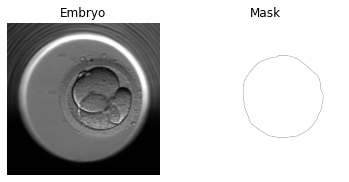

In [13]:
ix = randint(0, len(files))
file_name = files[ix]
n=file_no(file_name)
if(file_name[0]=='M'):
  mask_img = img_arr(path,file_name)
  emb_img = img_arr(path,'Embryo_'+n+'.jpg')
else :
  print("1")
  emb_img = img_arr(path, file_name)
  mask_img = img_arr(path,'Mask_'+n+'.jpg')

img = [emb_img, mask_img]
print(mask_img.shape)
titles = ["Embryo", "Mask"]
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(img[i])
  plt.title(titles[i])
  plt.axis("off")  
  




In [14]:
X = []

for file in files:
  if(file[0]=='M'):
    continue
  else :
    try:
      img = Image.open(os.path.join(path, file))
      emb_img =  img_arr(path, file)
      n = file_no(file)
      mask_img = img_arr(path, 'Mask_'+n+'.jpg')
      X.append(file)
    except:
      print("Image not opened!!")

Image not opened!!


In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transforms = A.Compose(
    [   
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        ToTensorV2(),
    ]
)

In [16]:
class ImageDataset(Dataset):
  def __init__(self, root_dir, X, transforms=None):
    self.root_dir = root_dir
    self.files = os.listdir(self.root_dir)
    self.transform = transforms

  def __len__(self):
    return len(X)

  def __getitem__(self, index):
    img_file = X[index]
    n = file_no(img_file)
    emb_img = img_arr(self.root_dir,img_file)
    mask_img = img_arr(self.root_dir, 'Mask_'+n+'.jpg')
    if self.transform:
      emb_img = self.transform(image=emb_img)['image']
      mask_img = self.transform(image = mask_img)['image'] 

    return emb_img, mask_img
    
        


In [17]:
dataset = ImageDataset(path,X, transforms)
train_set, test_set = torch.utils.data.random_split(dataset, [1650, 183])

train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle=True)


torch.float64
torch.Size([16, 4, 256, 256])
tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([16, 1, 256, 256])
torch.float64
torch.Size([16, 4, 256, 256])


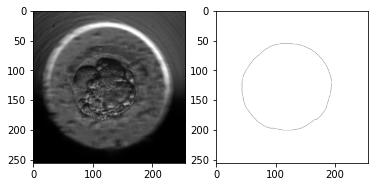

In [18]:
for idx, (x, y) in enumerate(train_loader):
  print(x.dtype)
  plt.subplot(1, 2, 1)
  plt.imshow(x[0].permute(1,2,0))
  plt.subplot(1, 2, 2)
  print(y.shape)
  print(torch.max(y), torch.min(y))
  print(y[:,0,:,:].unsqueeze(1).shape)
  plt.imshow(y[0].permute(1,2,0))
  print(y.dtype)
  print(y.shape)

  break

### Trainig of Model

In [19]:
unet = UNET(in_channels = CHANNELS_IMG , features=FEATURES).to(device)
opt = optim.Adam(unet.parameters(), lr=LEARNING_RATE,betas=(0.5, 0.999))
criterion = nn.BCELoss()


In [20]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.6 MB/s 
     |████████████████████████████████| 157 kB 62.2 MB/s 
     |████████████████████████████████| 181 kB 66.4 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 157 kB 68.1 MB/s 
     |████████████████████████████████| 157 kB 66.5 MB/s 
     |████████████████████████████████| 157 kB 78.5 MB/s 
     |████████████████████████████████| 157 kB 66.5 MB/s 
     |████████████████████████████████| 156 kB 70.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=89b8b8f16580b1dc1850bd778046a629cfa8a20ac6431863d70cfa0eb7aefcd9
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [21]:
import wandb
from torchvision.utils import make_grid

In [22]:
ALPHA = 0.5
BETA = 0.5

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        return 1 - Tversky

In [23]:
criterion = TverskyLoss()

In [24]:
step = 0
unet.train()

UNET(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): CNNBlocks(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): CNNBlocks(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): CNNBlocks(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

In [25]:
from torch.cuda import device_count

wandb.init("task-02")

for epoch in range(EPOCHS):
  print(f"Epoch {epoch}: ", end ="")

  for idx , (emb_img, mask_img) in enumerate(train_loader):
    emb_img = emb_img.to(device)
    mask_img = mask_img.float()
    mask_img = mask_img.to(device)
    predicted_mask = unet(emb_img.float())

    loss = criterion(predicted_mask, mask_img[:,0,:,:].unsqueeze(1))

    unet.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

  wandb.log({"LOSS : " : loss, 'epoch' : epoch})  
  with torch.inference_mode():
    for batch_idx, (emb_img, mask_img) in enumerate(test_loader):
      emb_img = emb_img.to(device)
      mask_img = mask_img.to(device)
      predicted_mask = unet(emb_img.float())
      grid1 = make_grid(emb_img)
      predicted_mask = predicted_mask.to(device)
      grid2 = make_grid(mask_img)
      grid3 = make_grid(predicted_mask)
      grid1 = wandb.Image(grid1, caption="Original Image")
      grid2 = wandb.Image(grid2, caption="Original Mask ")
      grid3 = wandb.Image(grid3, caption="Predicted Mask")
      wandb.log({"Original Image ": grid1})
      wandb.log({"Original Mask ": grid2})
      wandb.log({"Predicted Mask " : grid3})

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Streaming output truncated to the last 5000 lines.
0.08346807956695557
0.07402968406677246
0.06393986940383911
0.12067455053329468
0.07022255659103394
0.07126480340957642
0.07973587512969971
0.04899299144744873
Epoch 2: 0.10650211572647095
0.08866196870803833
0.10864239931106567
0.0870712399482727
0.06270217895507812
0.05696302652359009
0.06677228212356567
0.06440526247024536
0.06767463684082031
0.09219491481781006
0.06126946210861206
0.09796184301376343
0.09803074598312378
0.06390130519866943
0.051136136054992676
0.10967361927032471
0.09142351150512695
0.12942427396774292
0.05809503793716431
0.07176709175109863
0.06729525327682495
0.0658758282661438
0.09013277292251587
0.07540065050125122
0.09710061550140381
0.07063436508178711
0.059993088245391846
0.06904977560043335
0.0644119381904602
0.054324328899383545
0.08360230922698975
0.05995410680770874
0.15106183290481567
0.07917338609695435
0.08509552478790283
0.06925910711288452
0.09565615653991699
0.09507066011428833
0.13202732801437378


### Saving and Loading model

In [26]:

%cd '/content/drive/MyDrive/model'

/content/drive/MyDrive/model


In [27]:
torch.save(unet.state_dict(), './unet06.pth')

In [28]:
model = UNET(in_channels = CHANNELS_IMG , features=FEATURES).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/model/unet06.pth'))
model.eval()

UNET(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): CNNBlocks(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): CNNBlocks(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): CNNBlocks(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

In [99]:
def out_preprocess(out):
  out = torch.stack((out[0],out[0],out[0],out[0]), axis=1)
  out = out[0].permute(1,2,0)
  return out

(500, 500, 4)


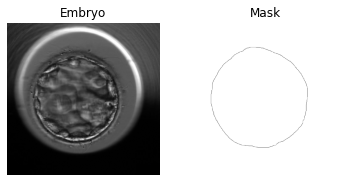

In [103]:
ix = randint(0, len(files))
file_name = files[ix]
n=file_no(file_name)
if(file_name[0]=='M'):
  mask_img = img_arr(path,file_name)
  emb_img = img_arr(path,'Embryo_'+n+'.jpg')
else :
  print("1")
  emb_img = img_arr(path, file_name)
  mask_img = img_arr(path,'Mask_'+n+'.jpg')

img = [emb_img, mask_img]
print(mask_img.shape)
titles = ["Embryo", "Mask"]
for i in range(2):
  img[i] = transforms(image=img[i])['image']
  plt.subplot(1,2,i+1)
  plt.imshow(img[i].permute(1,2,0))
  plt.title(titles[i])
  plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

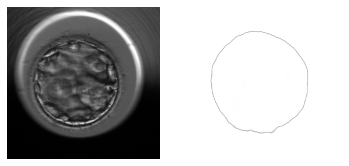

In [104]:
img = emb_img 
img = transforms(image=img)['image']
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.axis("off")
img = torch.unsqueeze(img, 0)
img = img.to(device)
out = model(img.float())
out = out.cpu().detach()
out = out_preprocess(out)
plt.subplot(1,2,2)
plt.imshow(out)
plt.axis("off")

